In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3818122/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Index Coop"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-13"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1052 non-null   object        
 1   author             1052 non-null   object        
 2   date               1052 non-null   datetime64[us]
 3   start              1052 non-null   datetime64[us]
 4   end                1052 non-null   datetime64[us]
 5   platform_proposal  1052 non-null   object        
dtypes: datetime64[us](3), object(3)
memory usage: 49.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24031 entries, 0 to 24030
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        24031 non-null  object        
 1   proposal  24031 non-null  object        
 2   voter     24031 non-null  object        
 3   date      24031 non-null  datetime64[us]
dtype

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Index Coop/baseline/folds-info_W-THU_normalize.parquet
fold
2023-05-11    23374
2023-05-18    23478
2023-05-25    23553
2023-06-01    23677
2023-06-08    23744
2023-06-15    23801
2023-06-22    23847
2023-06-29    23908
2023-07-06    23954
2023-07-13    24006
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W19,10,70,21,7.00,3.33,33,10,3.30,3.30
2023-W20,16,48,9,3.00,5.33,22,8,1.38,2.75
2023-W21,4,9,4,2.25,2.25,14,10,3.50,1.40
2023-W22,3,18,8,6.00,2.25,6,6,2.00,1.00
2023-W23,3,4,2,1.33,2.00,7,6,2.33,1.17
2023-W24,10,19,12,1.90,1.58,18,6,1.80,3.00
2023-W25,2,2,2,1.00,1.00,9,7,4.50,1.29
2023-W26,10,30,9,3.00,3.33,8,7,0.80,1.14
2023-W27,4,5,2,1.25,2.50,25,9,6.25,2.78


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W19 & 10 & 70 & 21 & 7.00 & 3.33 & 33 & 10 & 3.30 & 3.30 \\
2023-W20 & 16 & 48 & 9 & 3.00 & 5.33 & 22 & 8 & 1.38 & 2.75 \\
2023-W21 & 4 & 9 & 4 & 2.25 & 2.25 & 14 & 10 & 3.50 & 1.40 \\
2023-W22 & 3 & 18 & 8 & 6.00 & 2.25 & 6 & 6 & 2.00 & 1.00 \\
2023-W23 & 3 & 4 & 2 & 1.33 & 2.00 & 7 & 6 & 2.33 & 1.17 \\
2023-W24 & 10 & 19 & 12 & 1.90 & 1.58 & 18 & 6 & 1.80 & 3.00 \\
2023-W25 & 2 & 2 & 2 & 1.00 & 1.00 & 9 & 7 & 4.50 & 1.29 \\
2023-W26 & 10 & 30 & 9 & 3.00 & 3.33 & 8 & 7 & 0.80 & 1.14 \\
2023-W27 & 4 & 5 & 2 & 1.25 & 2.50 & 25 & 9 & 6.25 & 2.78 \\
2023-W28 & 8 & 18 & 8 & 2.25 & 2.25 & 11 & 4 & 1.38 & 2.75 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/139 [00:00<?, ?it/s]

Warning, empty test fold 0 (2020-11-19 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2020-11-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2020-12-03 00:00:00), all ok since 1 folds ago
Warning, test fold 3 (2020-12-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 4 (2020-12-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 5 (2020-12-24 00:00:00), all ok since 3 folds ago
Warning, empty test fold 6 (2020-12-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 7 (2021-01-07 00:00:00), all ok since 1 folds ago
Warning, test fold 8 (2021-01-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 9 (2021-01-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 10 (2021-01-28 00:00:00), all ok since 3 folds ago
Warning, test fold 11 (2021-02-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 12 (2021-02-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 13 (2021-02-18 00:00:00), all ok since 3 folds ago
Warning, test fold 14 (2021-02-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 15 (2021-03-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 16 (2021-03-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 17 (2021-03-18 00:00:00), all ok since 4 folds ago
Warning, test fold 18 (2021-03-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 19 (2021-04-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 20 (2021-04-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 21 (2021-04-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 23 (2021-04-29 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 25 (2021-05-13 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 26 (2021-05-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 27 (2021-05-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 28 (2021-06-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 29 (2021-06-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 30 (2021-06-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 31 (2021-06-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 32 (2021-07-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 34 (2021-07-15 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 35 (2021-07-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 39 (2021-08-19 00:00:00) with less than 5 open proposals (2). all ok since 4 folds ago


Warning, test fold 40 (2021-08-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 41 (2021-09-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 42 (2021-09-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 43 (2021-09-16 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 44 (2021-09-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 46 (2021-10-07 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 47 (2021-10-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 49 (2021-10-28 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 52 (2021-11-18 00:00:00) with less than 5 open proposals (4). all ok since 3 folds ago


Warning, test fold 53 (2021-11-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 55 (2021-12-09 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 57 (2021-12-23 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 58 (2021-12-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 61 (2022-01-20 00:00:00) with less than 5 open proposals (4). all ok since 3 folds ago


Warning, test fold 63 (2022-02-03 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 64 (2022-02-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 65 (2022-02-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 67 (2022-03-03 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 68 (2022-03-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 71 (2022-03-31 00:00:00) with less than 5 open proposals (1). all ok since 3 folds ago


Warning, test fold 73 (2022-04-14 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, empty test fold 74 (2022-04-21 00:00:00), all ok since 57 folds ago
Warning, test fold 75 (2022-04-28 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 76 (2022-05-05 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 77 (2022-05-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 78 (2022-05-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 79 (2022-05-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 80 (2022-06-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 82 (2022-06-16 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 83 (2022-06-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 84 (2022-06-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 85 (2022-07-07 00:00:00), all ok since 11 folds ago
Warning, test fold 86 (2022-07-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 87 (2022-07-21 00:00:00), all ok since 2 folds ago
Warning, test fold 88 (2022-07-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 89 (2022-08-04 00:00:00), all ok since 2 folds ago
Warning, test fold 90 (2022-08-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 92 (2022-08-25 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, empty test fold 94 (2022-09-08 00:00:00), all ok since 5 folds ago


Warning, test fold 97 (2022-09-29 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, test fold 98 (2022-10-06 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 99 (2022-10-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 100 (2022-10-20 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 103 (2022-11-10 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, test fold 104 (2022-11-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 106 (2022-12-01 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 110 (2022-12-29 00:00:00) with less than 5 open proposals (1). all ok since 4 folds ago


Warning, empty test fold 113 (2023-01-19 00:00:00), all ok since 19 folds ago
Warning, empty test fold 114 (2023-01-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 115 (2023-02-02 00:00:00), all ok since 1 folds ago


Warning, test fold 122 (2023-03-23 00:00:00) with less than 5 open proposals (2). all ok since 7 folds ago


Warning, test fold 126 (2023-04-20 00:00:00) with less than 5 open proposals (4). all ok since 4 folds ago


Warning, test fold 131 (2023-05-25 00:00:00) with less than 5 open proposals (4). all ok since 5 folds ago


Warning, test fold 132 (2023-06-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 133 (2023-06-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 135 (2023-06-22 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 137 (2023-07-06 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Max ok in a row: (57, Timestamp('2022-04-21 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Index Coop/baseline/openpop_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,...,139.000000,139.000000,139.000000,139.000000,139.000000,138.000000,138.000000,138.000000,138.000000,139.000000
mean,0.505517,0.335204,0.249468,0.138934,0.093654,0.014057,0.499754,0.590848,0.632189,0.649055,...,0.788153,0.794850,0.794950,0.563778,0.701208,0.739587,0.753230,0.753255,0.753255,0.116795
std,0.340587,0.190506,0.139919,0.082077,0.055898,0.008398,0.341224,0.349267,0.338163,0.330867,...,0.364016,0.364092,0.364147,0.334437,0.341949,0.331854,0.327313,0.327318,0.327318,0.019165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067421
25%,0.244048,0.256360,0.200000,0.100000,0.066667,0.010000,0.235714,0.309067,0.449418,0.492532,...,0.696305,0.723767,0.723767,0.339841,0.550000,0.631250,0.669872,0.669872,0.669872,0.120335
50%,0.480000,0.333333,0.243478,0.138372,0.094118,0.014118,0.480000,0.683083,0.750241,0.750241,...,1.000000,1.000000,1.000000,0.607143,0.800000,0.853274,0.887745,0.887745,0.887745,0.122674
75%,0.788889,0.450980,0.327619,0.187083,0.125463,0.018819,0.788889,0.910413,0.915225,0.915225,...,1.000000,1.000000,1.000000,0.859127,1.000000,1.000000,1.000000,1.000000,1.000000,0.125612
max,1.000000,0.800000,0.576471,0.335714,0.236667,0.035500,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.144458


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Index Coop/baseline/perfect_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,0.877698,0.453613,0.298449,0.154826,0.103278,0.015492,0.877698,0.877698,0.877698,0.877698,...,0.877615,0.877698,0.877698,0.674862,0.844954,0.870333,0.877615,0.877698,0.877698,0.121956
std,0.328819,0.223539,0.165192,0.090456,0.060426,0.009064,0.328819,0.328819,0.328819,0.328819,...,0.328789,0.328819,0.328819,0.305721,0.321120,0.326584,0.328789,0.328819,0.328819,0.019074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071133
25%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.559375,0.901994,0.973408,1.000000,1.000000,1.000000,0.126051
50%,1.000000,0.470588,0.288889,0.145455,0.096970,0.014545,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127610
75%,1.000000,0.606061,0.400000,0.208466,0.138977,0.020847,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,0.130021
max,1.000000,0.962963,0.711111,0.380000,0.253333,0.038000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.147320


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,139,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,...,139.000000,139.000000,139.000000,138.000000,138.000000,138.000000,138.000000,139.000000,0.0,0.0
mean,2022-03-17 00:00:00,0.505517,0.335204,0.249468,0.138934,0.093654,0.014057,0.499754,0.590848,0.632189,...,0.794950,0.563778,0.701208,0.739587,0.753230,0.753255,0.753255,0.116795,NaN,NaN
min,2020-11-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067421,NaN,NaN
25%,2021-07-18 12:00:00,0.244048,0.256360,0.200000,0.100000,0.066667,0.010000,0.235714,0.309067,0.449418,...,0.723767,0.339841,0.550000,0.631250,0.669872,0.669872,0.669872,0.120335,NaN,NaN
50%,2022-03-17 00:00:00,0.480000,0.333333,0.243478,0.138372,0.094118,0.014118,0.480000,0.683083,0.750241,...,1.000000,0.607143,0.800000,0.853274,0.887745,0.887745,0.887745,0.122674,NaN,NaN
75%,2022-11-13 12:00:00,0.788889,0.450980,0.327619,0.187083,0.125463,0.018819,0.788889,0.910413,0.915225,...,1.000000,0.859127,1.000000,1.000000,1.000000,1.000000,1.000000,0.125612,NaN,NaN
max,2023-07-13 00:00:00,1.000000,0.800000,0.576471,0.335714,0.236667,0.035500,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.144458,NaN,NaN
std,NaN,0.340587,0.190506,0.139919,0.082077,0.055898,0.008398,0.341224,0.349267,0.338163,...,0.364147,0.334437,0.341949,0.331854,0.327313,0.327318,0.327318,0.019165,NaN,NaN


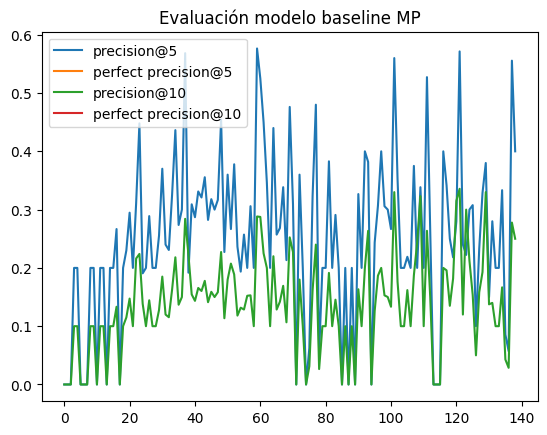

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,9.000000,9.000000,9.000000,9.000000,10.000000,0.0,0.0
mean,2023-06-11 12:00:00,0.370357,0.274101,0.264175,0.157337,0.113225,0.017109,0.345357,0.418703,0.519397,...,0.816101,0.559375,0.614516,0.752302,0.788589,0.788589,0.788589,0.121238,NaN,NaN
min,2023-05-11 00:00:00,0.000000,0.000000,0.057143,0.028571,0.019048,0.002857,0.000000,0.000000,0.110529,...,0.285714,0.000000,0.000000,0.444444,0.555556,0.555556,0.555556,0.109754,NaN,NaN
25%,2023-05-26 18:00:00,0.135417,0.165476,0.162500,0.100000,0.066667,0.010000,0.135417,0.299823,0.351431,...,0.778125,0.298611,0.458661,0.666667,0.666667,0.666667,0.666667,0.120988,NaN,NaN
50%,2023-06-11 12:00:00,0.364286,0.288889,0.240000,0.138750,0.102222,0.015333,0.364286,0.447400,0.595726,...,0.984375,0.614583,0.677083,0.812500,0.812500,0.812500,0.812500,0.121856,NaN,NaN
75%,2023-06-27 06:00:00,0.625000,0.333333,0.368333,0.229167,0.172917,0.026875,0.500000,0.604109,0.688310,...,1.000000,0.780382,0.843750,0.875000,0.888889,0.888889,0.888889,0.123213,NaN,NaN
max,2023-07-13 00:00:00,0.750000,0.703704,0.555556,0.330000,0.220000,0.033000,0.666667,0.783678,0.880388,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.124990,NaN,NaN
std,NaN,0.270148,0.190374,0.155557,0.099971,0.069938,0.010620,0.241120,0.248304,0.250222,...,0.291247,0.352690,0.316696,0.187998,0.159546,0.159546,0.159546,0.004310,NaN,NaN
